In [1]:
from typing_extensions import TypedDict, Annotated
from typing import Dict, List
import os

from langgraph.graph.message import add_messages
import operator

from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from pydantic import BaseModel, Field

from scripts import my_tools

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# =============================================================================
# Configuration
# =============================================================================

BASE_URL = "http://localhost:11434"

LLM_MODEL = "qwen3"
# LLM_MODEL = "gpt-oss"
MAX_ITERATIONS = 3
llm = ChatOllama(model=LLM_MODEL, base_url=BASE_URL)

In [3]:
# =============================================================================
# Pydantic Schemas for Structured Output
# =============================================================================

class Reflection(BaseModel):
    """Critique of current answer."""
    missing: str = Field(description="What critical information is missing or incomplete")
    superfluous: str = Field(description="What information is unnecessary or redundant")

class Answer(BaseModel):
    """Answer with inline citations, reflection, and search queries."""
    answer: str = Field(
        description="Detailed answer (~250-300 words) with inline citations [1], [2] and reference list at the end"
    )
    reflection: Reflection = Field(description="Critical reflection on the answer")
    search_queries: List[str] = Field(
        default_factory=list,
        description="1-3 search queries if more information needed, empty if complete"
    )
    is_complete: bool = Field(
        default=False,
        description="True if answer is complete and no more searches needed"
    )

In [4]:
# =============================================================================
# State
# =============================================================================

class AgentState(TypedDict):
    """State for reflexion RAG system."""
    messages: Annotated[List, add_messages]
    iteration_count: int
    retrieved_docs: str
    search_queries: List[str]
    is_complete: bool

In [5]:
# =============================================================================
# LangGraph Nodes
# =============================================================================

def draft_node(state: AgentState) -> Dict:
    """Generate initial answer with reflection."""
    print("\n[NODE] Draft - Generating initial answer")
    
    llm_structured = llm.with_structured_output(Answer)
    
    system_prompt = """You are an expert financial document researcher.

TASK:
1. Provide detailed answer (~250 words) to user's question
2. Use Markdown formatting (headings, bullets, tables, bold)
3. Reflect critically: identify missing and superfluous information
4. Generate 1-3 specific search queries to retrieve missing information

Format your answer with inline citations [1], [2] if you have any prior knowledge to cite, otherwise note what information you need.

Output JSON matching this schema:
{
  "answer": "Your detailed answer with inline citations [1] and references at the end...",
  "reflection": {
    "missing": "What information is missing...",
    "superfluous": "What is unnecessary..."
  },
  "search_queries": ["specific query 1", "specific query 2"],
  "is_complete": false
}"""
    
    messages = [SystemMessage(content=system_prompt)] + state["messages"]
    response = llm_structured.invoke(messages)
    
    print(f"[DRAFT] Generated answer with {len(response.search_queries)} search queries")
    print(f"[REFLECTION] Missing: {response.reflection.missing[:100]}...")
    
    ai_message = AIMessage(
        content=f"**Answer:**\n\n{response.answer}\n\n"
                f"**Reflection:**\n- Missing: {response.reflection.missing}\n"
                f"- Superfluous: {response.reflection.superfluous}\n\n"
                f"**Search Queries:** {', '.join(response.search_queries)}"
    )
    
    return {
        "messages": [ai_message],
        "iteration_count": 1,
        "search_queries": response.search_queries
    }

In [6]:
def retrieve_node(state: AgentState) -> Dict:
    """Execute search queries and retrieve documents."""
    print("\n[NODE] Retrieve - Fetching documents")
    
    # Get search queries from the last state update
    search_queries = state.get("search_queries", [])
    
    if not search_queries:
        print("[RETRIEVE] No search queries found, skipping retrieval")
        return {"retrieved_docs": ""}
    
    # Process each query using my_tools.retrieve_docs
    print(f"\n[RETRIEVAL] Processing {len(search_queries)} queries")
    
    all_retrieved_text = []
    
    for query_idx, query in enumerate(search_queries, 1):
        print(f"[QUERY {query_idx}] {query}")
        
        # Call my_tools.retrieve_docs for each query
        result = my_tools.retrieve_docs.invoke({'query': query, 'k': 3})
        
        # Format with query header
        all_retrieved_text.append(f"\n--- Query {query_idx}: {query} ---\n{result}")
    
    # Combine all results
    combined_result = "\n\n".join(all_retrieved_text)
    
    # Save for debugging
    os.makedirs("debug_logs", exist_ok=True)
    with open("debug_logs/reflexion_retrieved_docs.md", "w", encoding="utf-8") as f:
        f.write(combined_result)    
    
    return {
        "retrieved_docs": combined_result
    }

In [7]:

def revise_node(state: AgentState) -> Dict:
    """Revise answer with new information."""
    print(f"\n[NODE] Revise - Iteration {state.get('iteration_count', 1)}")
    
    llm_structured = llm.with_structured_output(Answer)
    retrieved_docs = state.get('retrieved_docs', 'No documents retrieved yet')
    
    system_prompt = """You are an expert financial document researcher.

TASK:
1. Write DETAILED answer (~250-300 words) with MARKDOWN formatting (## headings, **bold**, bullets, tables)
2. Include inline citations [1], [2] in the answer text
3. Add reference list at the end: "[1] Company: x, Year: y, Quarter: z, Page: n"
4. Critically reflect on what's missing or superfluous
5. Generate 2-3 SPECIFIC search queries if information is incomplete

CRITICAL - Search Query Rules:
- Use specific keywords: company name, year, quarter, metric type
- Good: "Amazon q1 q2 2023 quarterly revenue", "Amazon 2023 AWS segment earnings"
- Bad: "Amazon revenue", "financial data"

DECISION LOGIC:
Ask yourself:
- Do I have complete quarterly breakdown? (Q1, Q2, Q3, Q4)
- Do I have segment-wise data if relevant?
- Do I have year-over-year comparisons?
- Do I have all metrics requested (revenue, income, margins, etc.)?
- Do I have all companies mentioned in the question?

If ALL needed information present:
{
  "answer": "## Complete answer with citations [1][2]...\n\n**References:**\n[1] Company: amazon, Year: 2023, Page: 5",
  "is_complete": true,
  "search_queries": [],
  "reflection": {"missing": "None", "superfluous": "None"}
}

If MISSING any required data:
{
  "answer": "## Answer with available data [1]...\n\n**References:**\n[1] Company: amazon, Year: 2023, Page: 5",
  "is_complete": false,
  "search_queries": ["specific query 1", "specific query 2"],
  "reflection": {"missing": "List exact gaps", "superfluous": "None"}
}

MANDATORY: If is_complete=false, you MUST provide 2-3 specific search_queries."""

    messages = [SystemMessage(content=system_prompt)] + \
                [state["messages"][-1]] + \
                [HumanMessage(content=f"RETRIEVED DOCUMENTS:\n{retrieved_docs}\n\nRevise your answer using these documents. Output JSON only.")]

    response = llm_structured.invoke(messages)
    
    # Safety check
    if not response.is_complete and not response.search_queries:
        print("[WARNING] No search queries provided but answer incomplete. Forcing completion.")
        response.is_complete = True
    
    print(f"[REVISE] Complete: {response.is_complete}")
    print(f"[REVISE] New queries: {len(response.search_queries)}")
    if response.search_queries:
        for i, q in enumerate(response.search_queries, 1):
            print(f"  => [{i}] {q}")
    
    ai_message = AIMessage(
        content=f"**Answer:**\n\n{response.answer}\n\n"
                f"**Reflection:**\n- Missing: {response.reflection.missing}\n"
                f"- Superfluous: {response.reflection.superfluous}\n\n"
                f"**Status:** {'Complete' if response.is_complete else 'Needs more information'}"
    )
    
    return {
        "messages": [ai_message],
        "iteration_count": state.get("iteration_count", 1) + 1,
        "search_queries": response.search_queries,
        "is_complete": response.is_complete
    }

In [8]:
# =============================================================================
# Router Logic
# =============================================================================

def should_continue(state: AgentState) -> str:
    """Decide whether to continue reflection loop or end."""
    iteration_count = state.get("iteration_count", 0)
    is_complete = state.get("is_complete", False)
    search_queries = state.get("search_queries", [])
    
    if is_complete or not search_queries or iteration_count >= MAX_ITERATIONS:
        reason = "complete" if is_complete else "no queries" if not search_queries else f"max iterations ({MAX_ITERATIONS})"
        print(f"[ROUTER] Ending - {reason}")
        return END
    
    print(f"[ROUTER] Iteration {iteration_count} - continuing to retrieve")
    return "retrieve"


In [9]:
# =============================================================================
# Build Graph
# =============================================================================

def create_reflexion_rag():
    """Build reflexion RAG graph."""
    print("\n[GRAPH] Building reflexion RAG workflow")
    
    builder = StateGraph(AgentState)

    # Add nodes
    builder.add_node("draft", draft_node)
    builder.add_node("retrieve", retrieve_node)
    builder.add_node("revise", revise_node)

    # Define edges
    builder.add_edge(START, "draft")
    builder.add_edge("draft", "retrieve")
    builder.add_edge("retrieve", "revise")
    builder.add_conditional_edges("revise", should_continue, ["retrieve", END])

    return builder.compile()


In [10]:
graph = create_reflexion_rag()


[GRAPH] Building reflexion RAG workflow


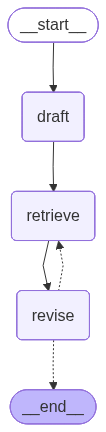

In [11]:
graph

In [12]:
result = graph.invoke({
        "messages": [HumanMessage(content="What was Amazon's balance sheet in 2023 fiscal year?")],
        "iteration_count": 0,
        "retrieved_docs": "",
        "search_queries": [],
        "is_complete": False
    })

result['messages'][-1].pretty_print()


[NODE] Draft - Generating initial answer
[DRAFT] Generated answer with 3 search queries
[REFLECTION] Missing: Exact numerical values for assets, liabilities, and equity are not provided due to lack of access to...

[NODE] Retrieve - Fetching documents

[RETRIEVAL] Processing 3 queries
[QUERY 1] Amazon 2023 10-K filing SEC

[TOOL] retrieve_docs called
[QUERY] Amazon 2023 10-K filing SEC
   [1] Doc 5: score=37.2672
   [2] Doc 2: score=32.5898
   [3] Doc 0: score=31.4766
[RETRIEVED] 3 documents
[QUERY 2] Amazon fiscal year 2023 balance sheet figures

[TOOL] retrieve_docs called
[QUERY] Amazon fiscal year 2023 balance sheet figures
   [1] Doc 7: score=24.1301
   [2] Doc 18: score=22.8476
   [3] Doc 11: score=21.9673
[RETRIEVED] 3 documents
[QUERY 3] Amazon investor relations financial statements 2023

[TOOL] retrieve_docs called
[QUERY] Amazon investor relations financial statements 2023
   [1] Doc 18: score=42.4272
   [2] Doc 8: score=35.0189
   [3] Doc 13: score=34.1048
[RETRIEVED] 3 do

In [13]:
result = graph.invoke({
        "messages": [HumanMessage(content="Compare the Amazon's and Apple's revenue of 2024 Q1?")],
        "iteration_count": 0,
        "retrieved_docs": "",
        "search_queries": [],
        "is_complete": False
    })

result['messages'][-1].pretty_print()


[NODE] Draft - Generating initial answer
[DRAFT] Generated answer with 3 search queries
[REFLECTION] Missing: The user’s question requires Q1 2024 revenue data, which is not yet publicly available. The answer i...

[NODE] Retrieve - Fetching documents

[RETRIEVAL] Processing 3 queries
[QUERY 1] Amazon Q1 2024 financial results

[TOOL] retrieve_docs called
[QUERY] Amazon Q1 2024 financial results
   [1] Doc 7: score=39.1338
   [2] Doc 8: score=32.6482
   [3] Doc 15: score=32.3791
[RETRIEVED] 3 documents
[QUERY 2] Apple Inc Q1 2024 revenue report

[TOOL] retrieve_docs called
[QUERY] Apple Inc Q1 2024 revenue report
   [1] Doc 1: score=21.6328
   [2] Doc 3: score=20.5197
   [3] Doc 0: score=17.8864
[RETRIEVED] 3 documents
[QUERY 3] Amazon vs Apple revenue 2024 Q1

[TOOL] retrieve_docs called
[QUERY] Amazon vs Apple revenue 2024 Q1
   [1] Doc 0: score=19.6071
   [2] Doc 20: score=19.3191
   [3] Doc 12: score=19.2325
[RETRIEVED] 3 documents

[NODE] Revise - Iteration 1
[WARNING] No search 

In [14]:
result = graph.invoke({
        "messages": [HumanMessage(content="Show segment wise earning for Iphones and Macbooks in 2023")],
        "iteration_count": 0,
        "retrieved_docs": "",
        "search_queries": [],
        "is_complete": False
    })

result['messages'][-1].pretty_print()


[NODE] Draft - Generating initial answer
[DRAFT] Generated answer with 3 search queries
[REFLECTION] Missing: Exact revenue breakdown for MacBooks within the Mac segment, profit margins for each segment, and 20...

[NODE] Retrieve - Fetching documents

[RETRIEVAL] Processing 3 queries
[QUERY 1] Apple Q4 2023 earnings report iPhone segment revenue

[TOOL] retrieve_docs called
[QUERY] Apple Q4 2023 earnings report iPhone segment revenue
   [1] Doc 2: score=17.7478
   [2] Doc 0: score=15.7569
   [3] Doc 1: score=13.5850
[RETRIEVED] 3 documents
[QUERY 2] Apple Mac segment revenue breakdown 2023

[TOOL] retrieve_docs called
[QUERY] Apple Mac segment revenue breakdown 2023
   [1] Doc 2: score=29.6977
   [2] Doc 10: score=23.1049
   [3] Doc 7: score=22.6846
[RETRIEVED] 3 documents
[QUERY 3] Apple financial statements 2023 product segment profits

[TOOL] retrieve_docs called
[QUERY] Apple financial statements 2023 product segment profits
   [1] Doc 0: score=32.5215
   [2] Doc 1: score=26.5961